<a href="https://colab.research.google.com/github/CossJe/Moguel/blob/main/PruebaFinalProyeccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import timedelta, date
import warnings
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def create_GoodDay_features4Pax(df_input, nombre, name):
    """
    Crea una columna binaria 'is_goodDay' en el DataFrame que indica si cada fecha es considerada
    un "buen día" de operación para una línea de transporte específica.

    Parámetros:
    -----------
    df_input : pandas.DataFrame
        DataFrame con índice tipo DateTimeIndex. Se espera que esté indexado por fechas.

    nombre : str
        Nombre corto de la línea (por ejemplo, "ETN", "PAR", "AME", etc.).
        Este valor determina qué días de la semana se consideran "buenos".

    name : str
        Nombre de la columna de valores a predecir (no se usa dentro de esta función pero se mantiene por compatibilidad).

    Retorna:
    --------
    pandas.DataFrame
        Copia del DataFrame original con una nueva columna 'is_goodDay' (1 para buen día, 0 en caso contrario).

    Nota:
    -----
    El mapeo de días considerados "buenos" por línea está codificado explícitamente.
    - Lunes = 0, Domingo = 6
    """

    df_output = df_input.copy()

    # Definir los días buenos según la línea
    if nombre == "ETN":
        good_days = [0, 3, 4, 6]  # Lunes, Jueves, Viernes, Domingo
    elif nombre == "PAR":
        good_days = [0, 4, 6]     # Lunes, Viernes, Domingo
    elif nombre == "AME":
        good_days = [0, 4, 5, 6]  # Lunes, Viernes, Sábado, Domingo
    elif nombre == "ARS":
        good_days = [0, 4, 5, 6]
    elif nombre == "SUR":
        good_days = [0, 1, 5, 6]  # Lunes, Martes, Sábado, Domingo
    elif nombre == "GHO":
        good_days = [0, 1, 5, 6]
    else:
        good_days = []  # Si la línea no está definida, no hay días buenos

    # Crear columna binaria is_goodDay: 1 si es buen día, 0 si no
    df_output['is_goodDay'] = df_output.index.dayofweek.isin(good_days).astype(int)

    return df_output


def Get_predictions4PAX(Frame, nombre, name, future_days):
    """
    Predice valores futuros de una serie temporal (como pasajeros) utilizando un modelo XGBoost.

    Esta función entrena un modelo basado en características como:
    - Días buenos específicos por línea
    - Día de la semana (con codificación one-hot)
    - Promedios y desviaciones móviles
    - Variables rezagadas (lags)

    Luego, predice de forma iterativa día por día hacia el futuro.

    Parámetros:
    -----------
    Frame : pandas.DataFrame
        DataFrame con índice datetime y columna de la variable objetivo.

    nombre : str
        Nombre de la línea (define qué días son "buenos").

    name : str
        Nombre de la columna a predecir (por ejemplo, 'PASAJEROS').

    future_days : int
        Número de días hacia el futuro a predecir.

    Retorna:
    --------
    pandas.Series
        Serie con fechas futuras como índice y predicciones como valores.
    """

    # --- Preparación inicial del DataFrame ---
    df = pd.DataFrame(Frame[name])
    df = df.rename(columns={name: 'y'})  # Se trabaja internamente con la columna 'y'

    # Agregar variable binaria 'is_goodDay' según la línea
    df = create_GoodDay_features4Pax(df, nombre, name)

    # Agregar nombre del día de la semana (Lunes, Martes, ...)
    df['DIA_SEMANA'] = df.index.day_name()

    # Copia para ingeniería de características
    df_processed = df.copy()
    df_processed['is_goodDay'] = df_processed['is_goodDay'].astype(bool)

    # --- Variables de ventana móvil ---
    N_rolling = 7
    df_processed[f'rolling_mean_{N_rolling}d'] = df_processed['y'].rolling(window=N_rolling).mean()
    df_processed[f'rolling_std_{N_rolling}d'] = df_processed['y'].rolling(window=N_rolling).std()

    # --- Lags ---
    for lag in [1, 2, 3, 4, 5, 6, 7]:
        df_processed[f'lag{lag}'] = df_processed['y'].shift(lag)

    # --- One-Hot Encoding para el día de la semana ---
    categorical_cols = ['DIA_SEMANA']
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, prefix=['day_of_week'])

    # Eliminar filas con NaNs creados por lags y rolling
    df_encoded.dropna(inplace=True)

    # --- División en entrenamiento y prueba ---
    EndTrain = round(len(df_encoded) * 0.80)
    data_train_encoded = df_encoded.iloc[:EndTrain]
    data_test_encoded = df_encoded.iloc[EndTrain:]

    y_train = data_train_encoded['y']
    y_test = data_test_encoded['y']
    X_train = data_train_encoded.drop(columns=['y'])
    X_test = data_test_encoded.drop(columns=['y'])

    # --- Entrenamiento del modelo XGBoost ---
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05
    )
    model.fit(X_train, y_train)

    # --- Fechas futuras a predecir ---
    last_historical_date = df.index.max()
    future_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1),
                                 periods=future_days, freq='D')

    future_df = pd.DataFrame(index=future_dates)
    future_df['y'] = np.nan  # Placeholder para los valores a predecir

    # Concatenar históricos con fechas futuras para mantener consistencia
    combined_df = pd.concat([df, future_df])

    # Recalcular variables temporales sobre el DataFrame combinado
    combined_df = create_GoodDay_features4Pax(combined_df, nombre, name)
    combined_df['DIA_SEMANA'] = combined_df.index.day_name()

    combined_df_processed = combined_df.copy()
    combined_df_processed['is_goodDay'] = combined_df_processed['is_goodDay'].astype(bool)
    combined_df_processed = combined_df_processed.reset_index().rename(columns={'index': 'date'})

    # --- Predicción iterativa día por día ---
    X_future_list = []

    # Inicializar buffers para rolling y lags
    rolling_window_data = df['y'].iloc[-N_rolling:].tolist()
    lag_data = df['y'].iloc[-7:].tolist()  # Máximo lag usado

    for i, current_date in enumerate(future_dates):
        temp_row_data = {}

        # Día bueno y nombre del día
        temp_row_data['is_goodDay'] = create_GoodDay_features4Pax(
            pd.DataFrame(index=[current_date]), nombre, name
        ).iloc[0]['is_goodDay'].astype(bool)
        temp_row_data['DIA_SEMANA'] = current_date.day_name()

        # Rolling
        if len(rolling_window_data) >= N_rolling:
            temp_row_data[f'rolling_mean_{N_rolling}d'] = np.mean(rolling_window_data[-N_rolling:])
            temp_row_data[f'rolling_std_{N_rolling}d'] = (
                np.std(rolling_window_data[-N_rolling:]) if len(rolling_window_data[-N_rolling:]) > 1 else 0.0
            )
        else:
            temp_row_data[f'rolling_mean_{N_rolling}d'] = np.mean(rolling_window_data) if rolling_window_data else np.nan
            temp_row_data[f'rolling_std_{N_rolling}d'] = np.std(rolling_window_data) if len(rolling_window_data) > 1 else 0.0

        # Lags
        for lag_val in [1, 2, 3, 4, 5, 6, 7]:
            temp_row_data[f'lag{lag_val}'] = lag_data[-lag_val] if len(lag_data) >= lag_val else np.nan

        # Preparar fila para predicción
        temp_future_df = pd.DataFrame([temp_row_data], index=[current_date])
        temp_future_df_encoded = pd.get_dummies(temp_future_df, columns=categorical_cols, prefix=['day_of_week'])

        # Asegurar todas las columnas necesarias
        missing_cols = set(X_train.columns) - set(temp_future_df_encoded.columns)
        for c in missing_cols:
            temp_future_df_encoded[c] = 0
        temp_future_df_encoded = temp_future_df_encoded[X_train.columns]

        # Predecir y almacenar
        predicted_y = model.predict(temp_future_df_encoded)[0]
        future_df.loc[current_date, 'y'] = predicted_y

        # Actualizar rolling y lags
        rolling_window_data.append(predicted_y)
        lag_data.append(predicted_y)

    # --- Resultado final ---
    final_future_predictions = future_df['y']
    return final_future_predictions


In [ ]:
uploaded = files.upload()

Saving ETN.xlsx to ETN.xlsx


In [ ]:
name="INGRESOS"
nombre=["ETN","PAR","AME","ARS","SUR","GHO"]
i=0
file=["ETN.xlsx","PAR.xlsx","AME.xlsx","ARS.xlsx","Sur.xlsx","GHO.xlsx"]
Frame = pd.read_excel(file[i],sheet_name=nombre[i])

if nombre[i] in ["SUR","GHO"]:
  Frame['Fecha Contable'] = pd.to_datetime(Frame['Fecha Contable'])
  Frame=Frame.set_index('Fecha Contable')
  Frame.index.name = 'Fecha'
else:
  Frame['ANIO-MES-DIA'] = pd.to_datetime(Frame['ANIO-MES-DIA'])
  Frame=Frame.set_index('ANIO-MES-DIA')
  Frame.index.name = 'Fecha'

In [3]:
import requests

name="INGRESOS"
nombre=["ETN","PAR","AME","ARS","SUR","GHO"]
i=0
file=["ETN.xlsx","PAR.xlsx","AME.xlsx","ARS.xlsx","Sur.xlsx","GHO.xlsx"]

excel_url = 'https://github.com/CossJe/Moguel/raw/main/ETN.xlsx'
file_name = 'ETN.xlsx'

response = requests.get(excel_url)
response.raise_for_status() # Raise an exception for bad status codes

with open(file_name, 'wb') as f:
    f.write(response.content)

print(f"File '{file_name}' downloaded successfully.")

# Now you can read the downloaded file
Frame = pd.read_excel(file_name, sheet_name=nombre[i])

if nombre[i] in ["SUR","GHO"]:
  Frame['Fecha Contable'] = pd.to_datetime(Frame['Fecha Contable'])
  Frame=Frame.set_index('Fecha Contable')
  Frame.index.name = 'Fecha'
else:
  Frame['ANIO-MES-DIA'] = pd.to_datetime(Frame['ANIO-MES-DIA'])
  Frame=Frame.set_index('ANIO-MES-DIA')
  Frame.index.name = 'Fecha'


Error al leer el archivo Excel: Excel file format cannot be determined, you must specify an engine manually.


In [ ]:
def filtrar_por_mes_anio(df, anios, mes_inicio, mes_fin):
    """
    Filtra un DataFrame con índice de fechas entre un rango definido de año y mes.

    Esta función devuelve un subconjunto del DataFrame cuyo índice (tipo datetime)
    se encuentre dentro del intervalo comprendido entre:
    - el primer día de `mes_inicio` del año `anios[0]`, y
    - el último día de `mes_fin` del año `anios[1]`.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con índice de tipo pandas.DatetimeIndex.

    anios : list o tuple de dos enteros
        Lista o tupla que contiene el año de inicio y el año de fin. Ejemplo: [2020, 2023]

    mes_inicio : int
        Mes de inicio del período (1 = enero, 12 = diciembre).

    mes_fin : int
        Mes de fin del período (1 = enero, 12 = diciembre).

    Retorna:
    --------
    pandas.DataFrame
        Subconjunto del DataFrame original, filtrado por el rango de fechas especificado.

    Errores:
    --------
    AttributeError : Si el índice del DataFrame no es de tipo pandas.DatetimeIndex.
    IndexError     : Si 'anios' no contiene al menos dos elementos.
    ValueError     : Si 'mes_inicio' o 'mes_fin' no están en el rango 1–12.
    """

    # --- Validaciones de entrada ---

    # Validar que el índice sea tipo datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise AttributeError("El índice del DataFrame debe ser de tipo pandas.DatetimeIndex.")

    # Validar que 'anios' tenga dos elementos
    if len(anios) < 2:
        raise IndexError("La lista 'anios' debe contener al menos dos elementos: [año_inicio, año_fin].")

    # Validar que los meses estén en rango válido
    if not (1 <= mes_inicio <= 12) or not (1 <= mes_fin <= 12):
        raise ValueError("Los valores de 'mes_inicio' y 'mes_fin' deben estar entre 1 y 12.")

    # --- Construcción de fechas límite ---

    # Fecha inicial: primer día del mes_inicio del año_inicio
    fecha_inicio = pd.Timestamp(anios[0], mes_inicio, 1)

    # Fecha final: último día del mes_fin del año_fin
    fecha_fin = pd.Timestamp(anios[1], mes_fin, 1) + pd.offsets.MonthEnd(0)

    # --- Aplicación del filtro ---
    return df[(df.index >= fecha_inicio) & (df.index <= fecha_fin)]

# Ejemplo de uso con el Frame existente:
anio_deseado = [2023,2024]
mes_deseado = 7
# Filtrar desde julio 2020 hasta junio 2023
Frame = filtrar_por_mes_anio(Frame, anio_deseado, mes_deseado-1, mes_deseado-1)

In [ ]:
def create_time_features(df_input):
    """
    Agrega características temporales a un DataFrame con índice tipo datetime.

    Este método genera columnas adicionales en el DataFrame de entrada basadas en el índice temporal.
    Las columnas añadidas son útiles para modelos de series temporales y análisis estacional.

    Parámetros:
    -----------
    df_input : pandas.DataFrame
        DataFrame con un índice de tipo datetime.

    Retorna:
    --------
    df_output : pandas.DataFrame
        Una copia del DataFrame original con las siguientes columnas adicionales:
        - 'year': año del índice.
        - 'month': mes del índice (1 a 12).
        - 'day_of_month': día del mes (1 a 31).
        - 'day_of_week': día de la semana (lunes=0, domingo=6).
        - 'week_of_year': número de semana del año (1 a 52 o 53).
        - 'day_of_year': número de día en el año (1 a 365 o 366).
        - 'is_weekend': 1 si el día es sábado o domingo, 0 en caso contrario.
    """
    # Hacemos una copia del DataFrame para no modificar el original
    df_output = df_input.copy()

    # Extraemos el año del índice de fecha
    df_output['year'] = df_output.index.year

    # Extraemos el mes (1 a 12)
    df_output['month'] = df_output.index.month

    # Extraemos el día del mes (1 a 31)
    df_output['day_of_month'] = df_output.index.day

    # Día de la semana, donde lunes=0 y domingo=6
    df_output['day_of_week'] = df_output.index.dayofweek

    # Número de semana del año según ISO (1 a 52/53)
    df_output['week_of_year'] = df_output.index.isocalendar().week.astype(int)

    # Día del año (1 a 365 o 366 si es bisiesto)
    df_output['day_of_year'] = df_output.index.dayofyear

    # Marca si el día es fin de semana: sábado (5) o domingo (6)
    df_output['is_weekend'] = df_output['day_of_week'].isin([5, 6]).astype(int)

    # Devolvemos el DataFrame enriquecido
    return df_output


In [ ]:
def create_GoodDay_features(df_input, nombre):
    """
    Agrega una columna 'is_goodDay' al DataFrame basada en días favorables por nombre de entidad.

    Dependiendo del valor de 'nombre', se consideran ciertos días de la semana como "buenos días".
    Se agrega una columna binaria donde 1 indica que el día es favorable y 0 en caso contrario.

    Parámetros:
    -----------
    df_input : pandas.DataFrame
        DataFrame con índice datetime.

    nombre : str
        Nombre de la entidad o grupo (por ejemplo: "ETN", "PAR", etc.)
        que determina qué días de la semana son considerados como buenos.

    Retorna:
    --------
    df_output : pandas.DataFrame
        Una copia del DataFrame original con una columna adicional:
        - 'is_goodDay': 1 si el día es favorable según la entidad, 0 en caso contrario.

    Notas:
    ------
    Los días de la semana están codificados como:
        Lunes=0, Martes=1, Miércoles=2, Jueves=3, Viernes=4, Sábado=5, Domingo=6
    """
    # Hacemos una copia del DataFrame original para no modificarlo directamente
    df_output = df_input.copy()

    # Para cada entidad, definimos qué días de la semana se consideran "buenos días"
    if nombre == "ETN":
        # Buenos días: lunes, jueves, viernes, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 3, 4, 6]).astype(int)
    elif nombre == "PAR":
        # Buenos días: lunes, viernes, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 4, 6]).astype(int)
    elif nombre == "AME":
        # Buenos días: lunes, viernes, sábado, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 4, 5, 6]).astype(int)
    elif nombre == "ARS":
        # Buenos días: lunes, viernes, sábado, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 4, 5, 6]).astype(int)
    elif nombre == "SUR":
        # Buenos días: lunes, martes, sábado, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 1, 5, 6]).astype(int)
    elif nombre == "GHO":
        # Buenos días: lunes, martes, sábado, domingo
        df_output['is_goodDay'] = df_output.index.dayofweek.isin([0, 1, 5, 6]).astype(int)

    # Devolvemos el DataFrame con la columna agregada
    return df_output


In [ ]:
def create_lag_features(df_input, target_col='INGRESOS', lags=[1, 7, 14, 30]):
    """
    Crea variables rezagadas (lags) y medias móviles del valor objetivo en un DataFrame.

    Esta función agrega columnas que contienen valores pasados (lags) del target especificado,
    así como medias móviles de 7 y 30 días basadas en valores rezagados, útiles para modelos de series de tiempo.

    Parámetros:
    -----------
    df_input : pandas.DataFrame
        DataFrame de entrada con columna de serie temporal y un índice datetime.

    target_col : str, opcional (por defecto='INGRESOS')
        Nombre de la columna objetivo sobre la cual se calcularán los rezagos y medias móviles.

    lags : list de int, opcional (por defecto=[1, 7, 14, 30])
        Lista de desfases (en días) a aplicar como variables rezagadas.

    Retorna:
    --------
    df_output : pandas.DataFrame
        Copia del DataFrame original con columnas adicionales:
        - '{target_col}_lag_{n}_dias': valor del target n días antes.
        - '{target_col}_rolling_mean_7d': media móvil de los últimos 7 días (excluyendo el día actual).
        - '{target_col}_rolling_mean_30d': media móvil de los últimos 30 días (excluyendo el día actual).

    Notas:
    ------
    - El cálculo de medias móviles usa `.shift(1)` para evitar fuga de información (data leakage).
    - Las nuevas columnas contendrán valores NaN al principio, correspondientes a los primeros días sin datos suficientes.
    """

    # Hacemos una copia del DataFrame original para no modificarlo directamente
    df_output = df_input.copy()

    # Creamos las variables rezagadas (lags) especificadas en la lista
    for lag in lags:
        df_output[f'{target_col}_lag_{lag}_dias'] = df_output[target_col].shift(lag)

    # Media móvil de 7 días, usando datos hasta el día anterior (shift(1) para evitar leakage)
    df_output[f'{target_col}_rolling_mean_7d'] = (
        df_output[target_col].shift(1).rolling(window=7).mean()
    )

    # Media móvil de 30 días, también basada en datos hasta el día anterior
    df_output[f'{target_col}_rolling_mean_30d'] = (
        df_output[target_col].shift(1).rolling(window=30).mean()
    )

    # Devolvemos el DataFrame con las nuevas columnas agregadas
    return df_output

In [ ]:
def add_monthly_day_type_averages(df_input, target_col='INGRESOS'):
    """
    Agrega promedios mensuales por tipo de día de la semana del mes anterior como nuevas columnas.

    Para cada fecha del DataFrame, esta función calcula y asigna los promedios del target_col
    correspondientes a cada tipo de día de la semana (lunes a domingo) en el **mes anterior**.
    Esto permite capturar patrones mensuales y estacionales diferenciados por día de la semana.

    Parámetros:
    -----------
    df_input : pandas.DataFrame
        DataFrame con índice datetime y columnas 'year', 'month', y 'day_of_week' ya generadas.

    target_col : str, opcional (por defecto='INGRESOS')
        Nombre de la columna de la que se calcularán los promedios.

    Retorna:
    --------
    df_output : pandas.DataFrame
        Una copia del DataFrame original con 7 nuevas columnas:
        - '{target_col}_avg_dia_semana_mes_anterior_0'  → promedio de lunes del mes anterior
        - ...
        - '{target_col}_avg_dia_semana_mes_anterior_6'  → promedio de domingo del mes anterior

    Notas:
    ------
    - Si no hay datos suficientes en el mes anterior para un tipo de día específico, el valor será NaN.
    - Esta función asume que ya se han creado las columnas 'year', 'month', y 'day_of_week'.
    """

    df_output = df_input.copy()

    # Asegurarse de que el DataFrame esté ordenado por fecha
    df_output = df_output.sort_index()

    # Guardar el nombre original del índice para restaurarlo más tarde
    original_index_name = df_output.index.name
    df_output.index.name = None  # Eliminar nombre del índice para evitar conflictos en el merge

    # Calcular promedio de ingresos por año, mes y día de la semana
    monthly_day_type_avg_overall = (
        df_output.groupby(['year', 'month', 'day_of_week'])[target_col]
        .mean()
        .reset_index()
    )
    monthly_day_type_avg_overall.columns = ['year', 'month', 'day_of_week', 'avg_sales']

    # Inicializar columnas para cada tipo de día (lunes a domingo)
    for day_type_idx in range(7):
        df_output[f'{target_col}_avg_dia_semana_mes_anterior_{day_type_idx}'] = np.nan

    # Iterar por cada fila del DataFrame
    for i in range(len(df_output)):
        current_date = df_output.index[i]

        # Obtener mes y año anterior a la fecha actual
        prev_month_date = current_date - pd.DateOffset(months=1)
        prev_month = prev_month_date.month
        prev_year = prev_month_date.year

        # Filtrar los promedios del mes anterior
        prev_month_averages_subset = monthly_day_type_avg_overall[
            (monthly_day_type_avg_overall['year'] == prev_year) &
            (monthly_day_type_avg_overall['month'] == prev_month)
        ]

        # Si hay datos disponibles para el mes anterior
        if not prev_month_averages_subset.empty:
            # Para cada día de la semana (0=Lunes, ..., 6=Domingo)
            for day_type_to_fill in range(7):
                avg_val_for_day_type = prev_month_averages_subset[
                    prev_month_averages_subset['day_of_week'] == day_type_to_fill
                ]['avg_sales']

                # Si existe promedio para ese tipo de día, asignarlo
                if not avg_val_for_day_type.empty:
                    df_output.loc[
                        current_date,
                        f'{target_col}_avg_dia_semana_mes_anterior_{day_type_to_fill}'
                    ] = avg_val_for_day_type.iloc[0]

    # Restaurar el nombre original del índice si existía
    if original_index_name is not None:
        df_output.index.name = original_index_name

    return df_output


In [ ]:
def TrainFitPredictAlgori(Frame, name, nombre):
    """
    Entrena un modelo XGBoost de regresión sobre una serie temporal con múltiples características
    y realiza predicciones tanto en el conjunto de prueba como en fechas futuras.

    Esta función realiza todo el flujo completo:
    - Ingeniería de características temporales y personalizadas
    - Entrenamiento y evaluación del modelo
    - Predicciones futuras basadas en el modelo entrenado

    Parámetros:
    -----------
    Frame : pandas.DataFrame
        DataFrame con índice datetime y columnas de datos históricos.

    name : str
        Nombre de la columna objetivo a predecir (ej. 'INGRESOS').

    nombre : str
        Nombre de la entidad o grupo, usado para aplicar la lógica de buenos días y en los títulos.

    Retorna:
    --------
    Frame_Train : pandas.DataFrame
        DataFrame con valores reales y predichos del conjunto de prueba.

    predictions_df : pandas.DataFrame
        DataFrame con predicciones futuras generadas por el modelo.
    """

    # --- Paso 1: Ingeniería de características ---
    df_features = create_time_features(Frame)
    df_features = create_lag_features(df_features, target_col=name)
    df_features = create_GoodDay_features(df_features, nombre)
    df_features = add_monthly_day_type_averages(df_features, target_col=name)

    # Eliminar filas con valores faltantes causados por rezagos y promedios móviles
    df_features.dropna(inplace=True)

    # --- Paso 2: División de datos en entrenamiento y prueba (80/20 temporal) ---
    split_idx = int(len(df_features) * 0.8)
    train = df_features.iloc[:split_idx]
    test = df_features.iloc[split_idx:]

    # --- Paso 3: Separar variables predictoras y objetivo ---
    X_train = train.drop(name, axis=1)
    y_train = train[name]
    X_test = test.drop(name, axis=1)
    y_test = test[name]

    # --- Paso 4: Entrenamiento del modelo XGBoost ---
    print("Entrenando modelo XGBoost...")

    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'rmse'
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

    print("\nModelo XGBoost entrenado exitosamente.")

    # --- Paso 5: Evaluación del modelo ---
    print("Evaluando el rendimiento del modelo...")
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Evaluación en el conjunto de prueba:")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE: {mae:.2f}")
    print(f"   R² : {r2:.4f}\n")

    # --- Visualización de predicciones en el conjunto de prueba ---
    plt.figure(figsize=(18, 7))
    plt.plot(y_test.index, y_test, label=f'{name} Reales', color='blue', alpha=0.7)
    plt.plot(y_test.index, predictions, label='Predicciones XGBoost', color='red', linestyle='--')
    plt.title(f'Reales vs. Predicciones XGBoost para {name} de {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Importancia de las características ---
    feature_importances = pd.DataFrame({
        'Característica': X_train.columns,
        'Importancia': model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("Importancia de las características (Top 10):")
    print(feature_importances.head(10).to_string())
    print("\n")

    # Guardar comparación reales vs. predicciones del test
    Frame_Train = pd.DataFrame({'Reales': y_test, 'Predicciones': predictions})

    # --- Paso 6: Predicción futura ---
    last_date = Frame.index.max()
    future_days = 10  # Número de días a predecir
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

    print(f"Predicciones para fechas futuras desde {future_dates.min().strftime('%Y-%m-%d')} hasta {future_dates.max().strftime('%Y-%m-%d')}")

    # Crear DataFrame vacío para las fechas futuras
    future_df = pd.DataFrame(index=future_dates)
    future_df[name] = np.nan

    # Concatenar datos históricos con fechas futuras para recalcular features
    combined_df = pd.concat([df_features, future_df])

    combined_df_features = create_time_features(combined_df)
    combined_df_features = create_lag_features(combined_df_features, target_col=name)
    combined_df_features = create_GoodDay_features(combined_df_features, nombre)
    combined_df_features = add_monthly_day_type_averages(combined_df_features, target_col=name)

    # Filtrar únicamente las fechas futuras
    X_future = combined_df_features.loc[future_dates]

    print(f"DataFrame de características para predicciones futuras creado con {len(X_future)} filas.")

    # --- Paso 7: Agregar predicción de otra variable (e.g. PASAJEROS) como input ---
    atributos = "PASAJEROS"
    Pre_Pax = Get_predictions4PAX(Frame, nombre, atributos, future_days)
    X_future.PASAJEROS = Pre_Pax

    # Eliminar columna 'INGRESOS' para evitar fugas si existe como NaN
    X_future.drop(columns=['INGRESOS'], inplace=True)

    # Realizar predicciones futuras
    future_predictions = model.predict(X_future)

    predictions_df = pd.DataFrame({'Fecha': X_future.index, 'Prediccion': future_predictions})
    predictions_df.set_index('Fecha', inplace=True)

    print("\nPredicciones Futuras:")
    print(predictions_df.head(), "\n")

    # --- Visualización de predicciones futuras + historial ---
    plt.figure(figsize=(18, 7))
    plt.plot(y_test.index, y_test, label=f'{name} Reales (Test)', color='blue', alpha=0.7)
    plt.plot(y_test.index, predictions, label='Predicciones XGBoost (Test)', color='red', linestyle='--')
    plt.plot(predictions_df.index, predictions_df['Prediccion'], label='Predicciones Futuras', color='green', marker='o', linestyle='-')

    plt.title(f'Datos Históricos Reales, Predicciones del Modelo y Futuras de {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)
    plt.show()

    return Frame_Train, predictions_df


Entrenando modelo XGBoost...

Modelo XGBoost entrenado exitosamente.
Evaluando el rendimiento del modelo...
Evaluación en el conjunto de prueba:
   RMSE: 335875.05
   MAE: 173342.70
   R² : 0.9349



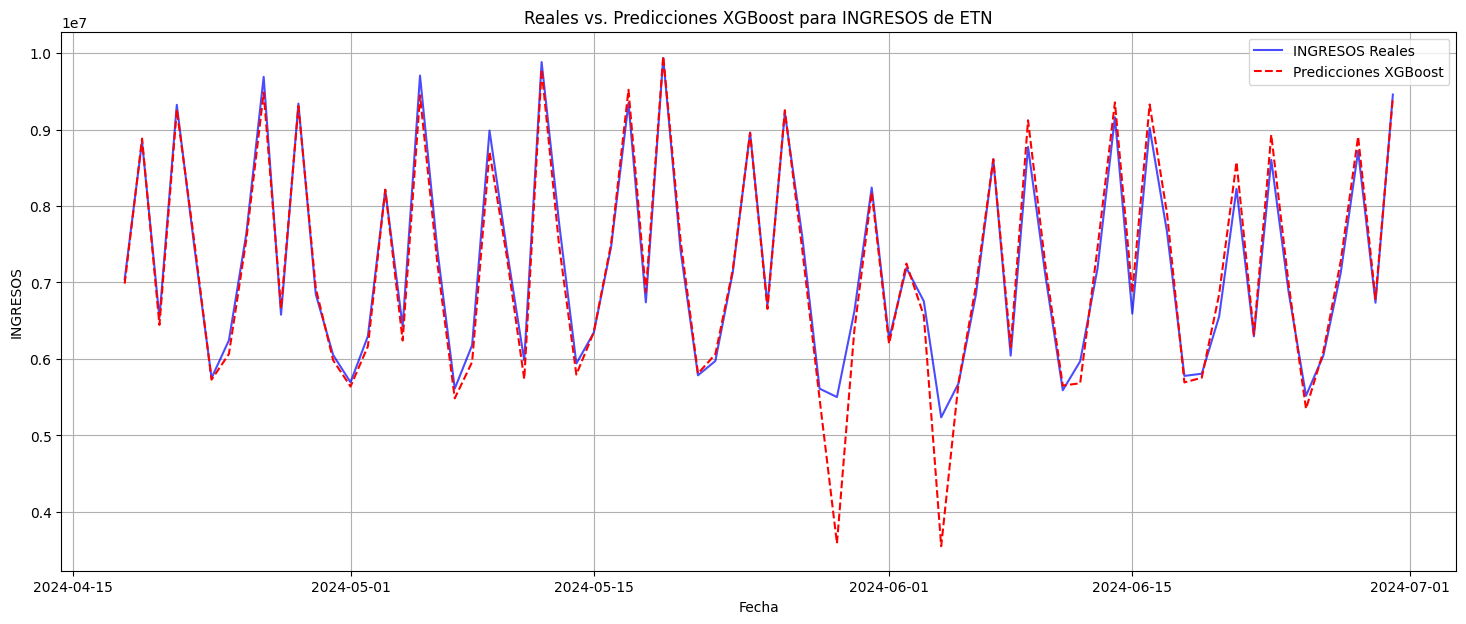

Importancia de las características (Top 10):
                            Característica  Importancia
2                                      FOP     0.404842
0                                PASAJEROS     0.388996
24  INGRESOS_avg_dia_semana_mes_anterior_6     0.063933
17                              is_goodDay     0.038901
1                                      KMS     0.032972
3                                SERVICIOS     0.022760
22  INGRESOS_avg_dia_semana_mes_anterior_4     0.008796
21  INGRESOS_avg_dia_semana_mes_anterior_3     0.008336
4                                     year     0.006889
5                                    month     0.006445


Predicciones para fechas futuras desde 2024-07-01 hasta 2024-07-10
DataFrame de características para predicciones futuras creado con 10 filas.

Predicciones Futuras:
            Prediccion
Fecha                 
2024-07-01  11896041.0
2024-07-02  11084469.0
2024-07-03  11090025.0
2024-07-04  11919090.0
2024-07-05  12583783.0 



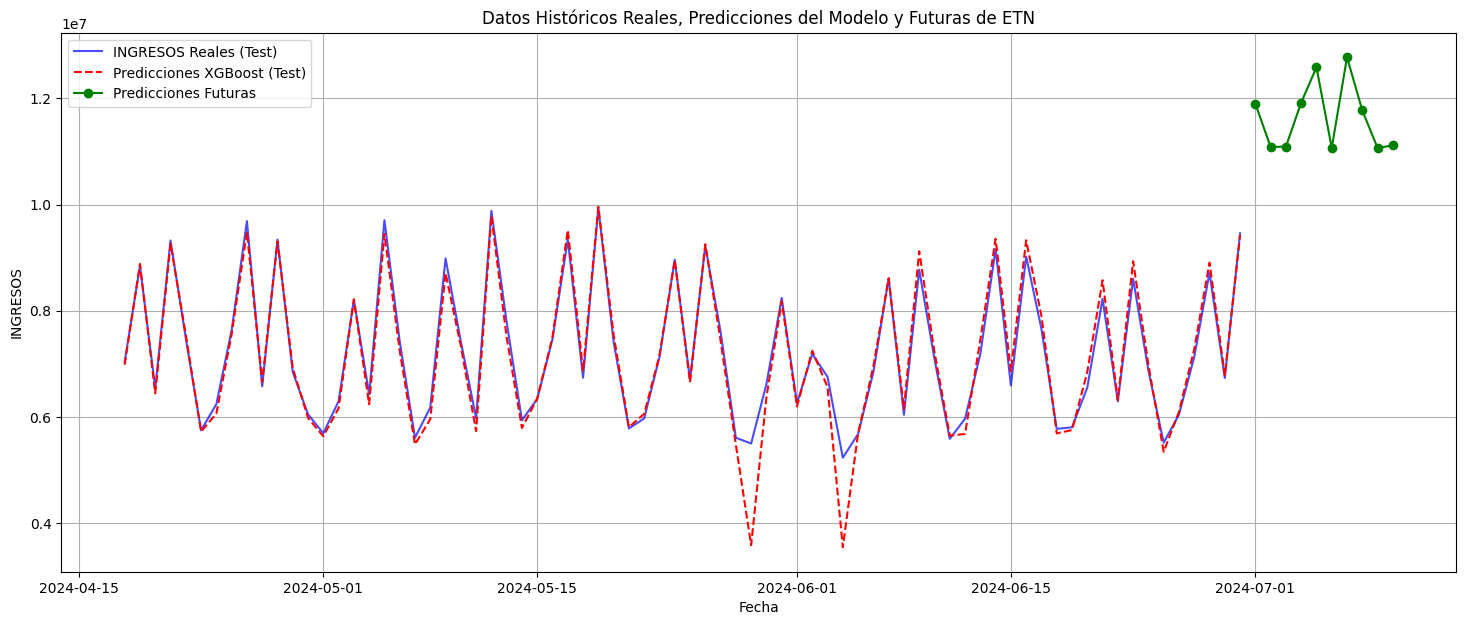

In [ ]:
Frame_Train,Frame_Future= TrainFitPredictAlgori(Frame,name,nombre[i])